Импорт библиотек

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics 
from collections import Counter
import ast
import numpy as np
from datetime import datetime, timedelta 

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

1) Restaurant_id — идентификационный номер ресторана / сети ресторанов;

2) City — город, в котором находится ресторан;

3) Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

4) Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

5) Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

6) Price Range — диапазон цен в ресторане;

7) Number of Reviews — количество отзывов о ресторане;

8) Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

9) URL_TA — URL страницы ресторана на TripAdvosor;

10) ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [139]:
RANDOM_SEED = 42
plt.rcParams['figure.figsize'] = (10,7)

In [140]:
raw_df = pd.read_csv('main_task.csv')
raw_df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


# EDA и предобработка признаков

In [141]:
#скопируем сырые данные в датафрейм, с которым будем работать и переименуем столбцы
df = raw_df
df.columns = df.columns.str.replace(' ','_').str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


### Признак 'city'

<AxesSubplot:>

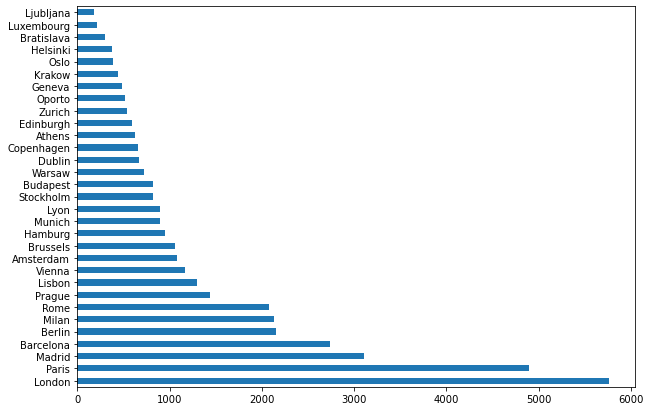

In [142]:
df['city'].value_counts().plot(kind='barh')

Видим, что часть городов выделяется по количеству ресторанов. Лондон, Париж - среди лидеров

<AxesSubplot:xlabel='rating', ylabel='city'>

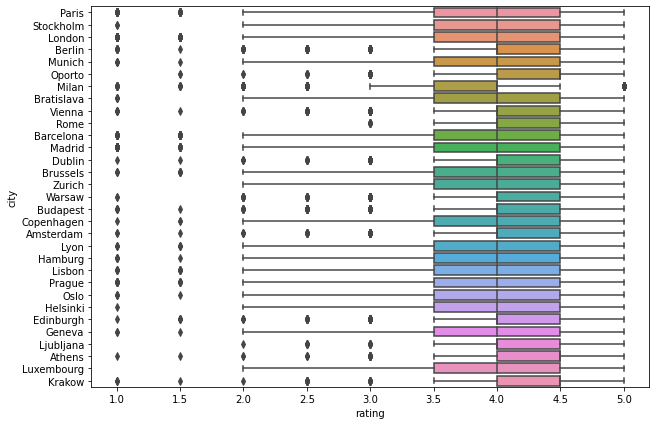

In [143]:
sns.boxplot(x='rating', y='city', data=df)

<AxesSubplot:xlabel='ranking', ylabel='city'>

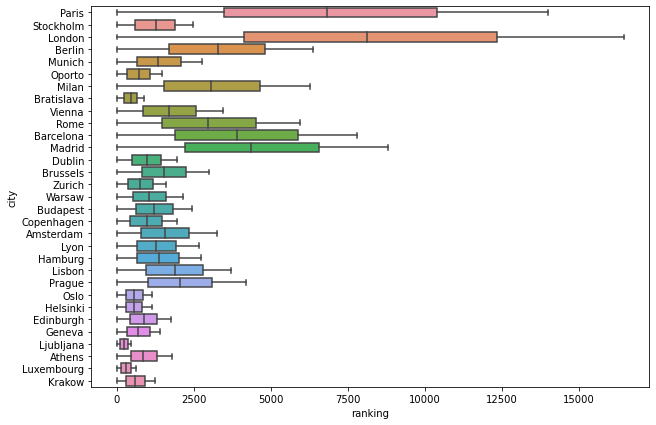

In [144]:
sns.boxplot(x='ranking', y='city', data=df)

Обращаем внимание на то, что максимальный ranking не соответствует количеству представленных ресторанов. 
Например, в Лондоне в нашем датасете примерно 5500 ресторанов, тогда как максимальный ranking близок к 16000
Видимо, это из-за того, что не все рестораны попали в датасет.

Выберем топ 7 городов по количству ресторанов и создадим для них dummy-переменные. В дальнейшем с цифрой 7 можно поиграться.

In [145]:
top_N_cities_list = df['city'].value_counts().index[:7] # отберем топ-7 городов по кол-ву ресторанов
df['top_N_city'] = df['city'].apply(lambda x: x if x in top_N_cities_list else 'Other')
city_dummy = pd.get_dummies(df['top_N_city'])
df = pd.concat([df, city_dummy], axis = 1)

Попробуем обогатить наши данные. Добавим признак, является ли город столицей

In [146]:
not_capitals_list = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
df['if_capital'] = df['city'].apply(lambda x: 0 if x in not_capitals_list else 1)

Добавим количество людей в городе (данные - википедия, 100 тыс. человек)

In [147]:
city_population_dict = {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
df['city_population'] = df.apply(lambda x: city_population_dict[x['city']], axis = 1)

Добавим кол-во ресторанов на 100 тыс чел в городе

In [148]:
# считаем, что max(ranking) - и есть максимальное количество ресторанов в городе
city_rest_num = df.groupby(['city'])['ranking'].max()
df['city_rest_num'] = df['city'].apply(lambda x: city_rest_num[x])
df['city_rest_density'] = df['city_population']/df['ranking']

**Итог по 'сity':**
- пропусков нет
- создали dummy для 7 городов с наибольшим количеством ресторанов (+ 'Other')
- 'if_capital' - признак, является ли город столицей
- 'city_population' - население города 
- 'city_rest_num' - количество ресторанов в городе
- 'city_rest_density' - плотность ресторанов на 100к населения

Идеи для будущего (на случай, когда за конкурс будут платить $30k):
- добавить кол-во туристов (и пересчитать плотность)
- добавить другую справочную информацию (страна, счастье людей в стране, соотношение туристов к населению и т.п.)

### Признак 'cuisine_style'

In [149]:
# видим много пропусков, чтобы не потерять эти данные - сформируем признак
df['is_nan_cuisine_style'] = pd.isna(df['cuisine_style']).astype('float64')

In [150]:
# судя по всему pands считывает список как строку (добавляя " в начле и конце, исправим это)
df['cuisine_style'] = df['cuisine_style'].str[2:-2].str.split("', '")
df['cuisine_style'] = df['cuisine_style'].fillna("['Other']")

In [151]:
# подсчитаем количество представленных типов кухонь для каждого ресторана
df['cuisine_num'] = df['cuisine_style'].str.len()

**Итог по 'cuisine_style':**
- Избавились от пропусков, добавив 'Other'
- 'is_nan_cuisine_style' для с ресторанов с NaN (на всякий случай)
- 'cuisine_num' - количество представленных кухонь

На будущее:
- можно выбрать уникальные и наиболее редкие виды кухонь и добавить признак по ним
- можно выбрать наиболее популярные виды кухонь в конкретном городе/стране и добавить признак по ним

### Признак 'ranking'

<AxesSubplot:>

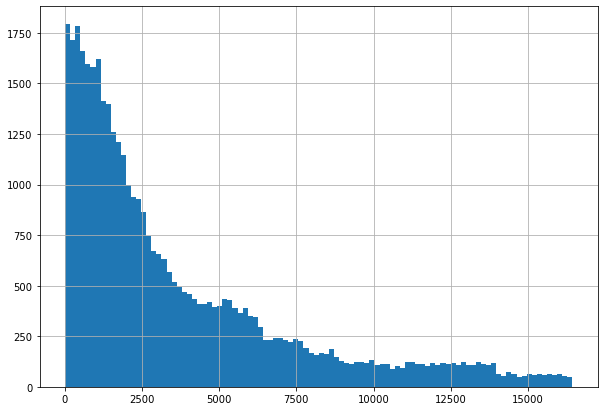

In [152]:
df['ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

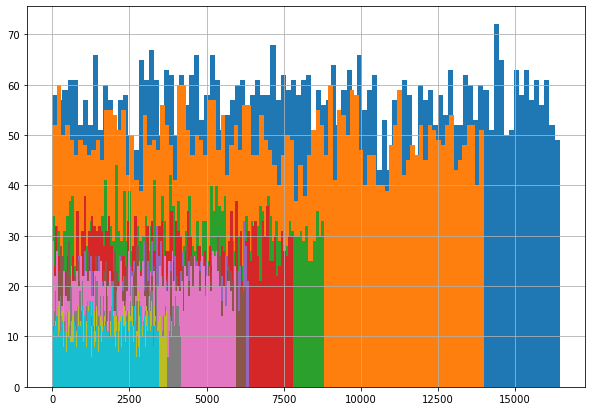

In [153]:
# посмотрим на топ 10 городов
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show()

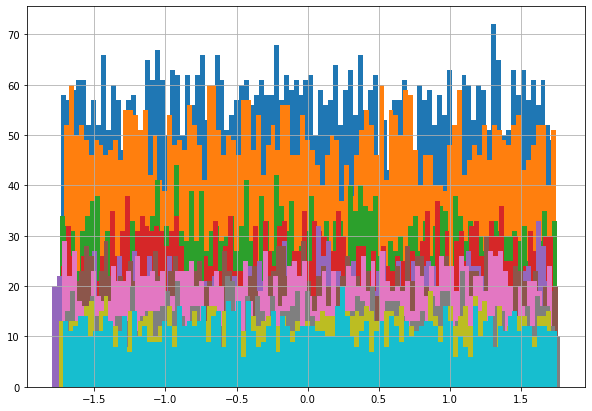

In [154]:
# тк в разных городах разное количество ресторанов, попробуем нормализовать ranking по городам
# и посмотреть н распределение
# для простоты решил воспользоваться формулой, а не StandardScaler
df['ranking_normalized'] = df.groupby('city')['ranking'].transform(lambda x: (x-x.mean())/x.std())
for x in (df['city'].value_counts())[0:10].index:
    df['ranking_normalized'][df['city'] == x].hist(bins=100)
plt.show()

In [155]:
# понятно, что 10 ресторан из 1000 и 10 ресторан из 10000 - это большая разница
# поэтому введем признак 'ranking_relative'
df['ranking_relative'] = df['ranking'] / df['city_rest_num']

**Итог по 'ranking':**
- Пропусков не было
- 'ranking_normalized' - нормализовали ранг внутри города
- 'ranking_relative' - относительный ранг ресторана в городе

### Признак 'price_range'

In [156]:
df['price_range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

Видим, что много пропусков, а более 70% ресторанов имеют среднюю ценовую категорию

In [157]:
#создадим отдельный признак для значений, где был NaN
df['is_nan_price_range'] = pd.isna(df['price_range']).astype('float64')

# здесь значения - порядковые, можем их закодировать
price_range_dict = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
df = df.replace({'price_range': price_range_dict})
df['price_range'] = df['price_range'].fillna(1)

**Итог по 'price_range':**:
- много пропусков (35%)
- закодировали признаки (0 - низкая цена, 1 - средняя, 2 - высокая)
- 'is_nan_price_range' - столбец с пропусками в ценовой категории
- пропуски заполнили модой (1)

### Признак 'number_of_reviews'

In [158]:
# в признаке 6% пропущенных значений - скорее всего, не было комментариев
# сохраним эту информацию
df['is_nan_number_of_reviews'] = pd.isna(df['number_of_reviews']).astype('float64')

# предположим, что NaN в number_of_reviews - это отсутствие комментариев, заменим на 0
# хотя это не совсем корректно, т.к. в столбце 'reviews' у некоторых таких ресторанов есть отзывы
df['number_of_reviews'].fillna(0, inplace=True)

**Итог по 'number_of_reviews':**
- пропуски заменили на 0
- 'is_nan_number_of_reviews' для столбцов с пропусками

На будущее:
- для пропусков в некоторых случаях можно взять данные из 'reviews'

### Признак 'reviews'

Попробуем разгрести столбец reviews - отделить даты самых старых и самых новых комментариев

In [159]:
def return_review_date(row, mode = 'newest'):
    '''replacing nan values from text reviews cause of ast.literal_eval error
       Function returns NaN if reviews are empty
       Function returns one date if it is only one review
       Function returns newest/oldest review according to mode'''
    
    str_review = ast.literal_eval(str(row['reviews']).replace('nan','0'))
    if str_review == [[], []]:
        return 'NaN'
    elif len(str_review[1]) == 1:
        return(datetime.strptime(str_review[1][0],'%m/%d/%Y'))
    else:
        first_review_time = datetime.strptime(str_review[1][0],'%m/%d/%Y')
        second_review_time = datetime.strptime(str_review[1][1],'%m/%d/%Y')
        if mode == 'newest':
            return max(second_review_time, first_review_time)
        else:
            return min(second_review_time, first_review_time)

df['reviews'].fillna('[[], []]', inplace=True)
df['newest_review_date'] = df.apply(lambda row:return_review_date(row, mode='newest'), axis=1)
df['eldest_review_date'] = df.apply(lambda row:return_review_date(row, mode='eldest'), axis=1)

In [160]:
# создадим признак для тех ресторанов, у которых нет обзоров вообще
df['is_nan_reviews'] = pd.isna(df['newest_review_date']).astype('float64')

In [161]:
# посмотрим на дату самого свежего обзора, предположим, что тогда датасет и собирался
newest_review_date = df['newest_review_date'].max()
newest_review_date

Timestamp('2018-02-26 00:00:00')

In [162]:
# посмотрим на дату самого старого обзора, учтем что Tripadviser был создан в 2000 году
oldest_review_date = df['eldest_review_date'].min()
oldest_review_date

Timestamp('2004-04-21 00:00:00')

In [163]:
# для ресторанов без отзывов добавим минимальную дату
df['newest_review_date'].fillna(oldest_review_date, inplace=True)
df['eldest_review_date'].fillna(oldest_review_date, inplace=True)

In [164]:
# Посчитаем разницу в днях между обзорами
# Предполагаем, что 'сегодня' = дата самого нового обзора в датасете
df['days_to_most_recent_review'] = (newest_review_date - df['newest_review_date']).dt.days
df['days_between_oldest_newest_reviews'] = (df['newest_review_date'] - df['eldest_review_date']).dt.days

In [165]:
# проверим работу функции
df[['reviews', 'newest_review_date', 'eldest_review_date', 'days_to_most_recent_review',
   'is_nan_reviews', 'days_between_oldest_newest_reviews']].sample(10)

,reviews,newest_review_date,eldest_review_date,days_to_most_recent_review,is_nan_reviews,days_between_oldest_newest_reviews
30246,"[['Average London pub', 'Nice Pub'], ['10/03/2...",2017-12-31,2017-10-03,57,0.0,89
18136,"[['Delicious Italian food', 'New Years Eve par...",2018-01-02,2017-12-23,55,0.0,10
22154,"[['People watching - good for food or coffee',...",2017-10-26,2017-10-09,123,0.0,17
21911,"[['Fantastic, authentic Italian food'], ['08/1...",2017-08-16,2017-08-16,194,0.0,0
22545,"[['Good value for money', 'Staff in Dog Mood']...",2017-11-23,2017-09-27,95,0.0,57
20316,"[['Evening', 'Nice location for a dinner in Al...",2017-01-26,2013-09-04,396,0.0,1240
529,"[['Lunch time treat'], ['12/31/2017']]",2017-12-31,2017-12-31,57,0.0,0
15588,"[['Not that good chinese food.', 'Below averag...",2017-02-09,2014-01-17,382,0.0,1119
25945,"[['Good🥘', 'more Indian than Turkish ... opens...",2017-10-26,2017-06-16,123,0.0,132
26462,"[['Hidden Gem', 'Petit, jolie....très bon rest...",2016-10-18,2015-11-23,496,0.0,330


**Итог по 'reviews'**: 
- 'newest_review_date' - дата последнего обзора
- 'eldest_review_date' - дата первого обзора (для ресторанов с 1 обзором = 'newest_review_date')
- у ресторанов без обзоров появился признак is_nan_reviews, даты обзора = дата самого ранего обзора в датасете
- 'days_to_most_recent_review' - кол-во дней от последнего обзора до сегодня (сегодня = 2018-02-26, предполагаемая дата сбора датасета)
- 'days_between_oldest_newest_reviews' - кол-во дней между обзорами

На будущее:
- тональность обзоров (самостоятельно по ключевым словам типа 'excellent' или через готовые пакеты)
- год последнего обзора, день недели последнего обзора

### Остальные признаки
- URL_TA — URL страницы ресторана на TripAdvosor, в нем закодирован индекс города, но вытаскивать и проверять не станем
- ID_TA — идентификатор ресторана в базе данных TripAdvisor. Есть предположение, что id инкрементный, значит, по нему можно судить о возрасте ресторана. Но отложим это на будущее

In [166]:
df = df.select_dtypes(exclude=['object','datetime64[ns]'])

<AxesSubplot:>

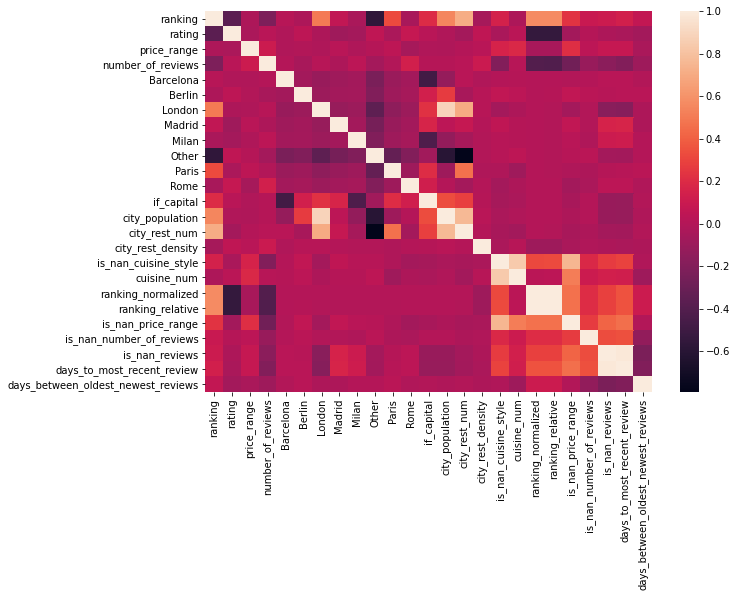

In [167]:
sns.heatmap(df.corr())

Есть довольно сильно коррелирующие мужду собой параметры, однако пока убирать их не будем, попробуе обучить модель как есть.
Нормализовывать данные также не будем, т.к. для деревьев в этом нет необходимости

In [168]:
def mae_test(data):
    y = data['rating']
    data.drop(['rating'], axis=1, inplace=True)
    X = data

    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 20% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED)

    # Создаём модель
    regr = RandomForestRegressor(
        n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)

    # Т. к. целевая переменная кратна 0.5, добавим здесь округление y_pred до 0.5
    y_pred = np.round(y_pred*2)/2

    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    print()
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print()

    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(
        kind='barh', title='Влияние признаков на МАЕ')

Поигрался с признаками, подаваемыми в модель, понял, что оптимальное количество dummy переменных для городов - 7 
и что надо убрать 'ranking из модели'. Наверное, можно дальше играться с оптимальными вариантами (например, собрать все возможные комбинации признаков, для всех рассчитать MAE и найти оптимальный вариант) - но на это не хватило времени.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



MAE: 0.1715



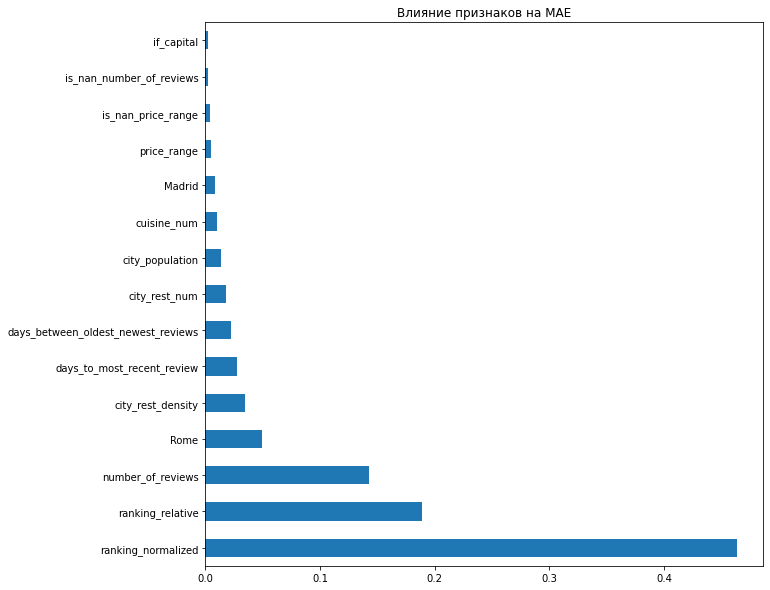

In [174]:
train_df = df.copy()
train_df.drop(['ranking'], axis=1, inplace=True)
mae_test(train_df)